In [3]:
%load_ext autoreload
%autoreload 2

import cryogrid_pytools as cgt
import pandas as pd

# Reading CryoGrid output

Currently only support for `read_OUT_regridded_FCI2`

In [18]:
fname = '/Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat/strat_10056_19830901.mat'
cgt.read_OUT_regridded_FCI2_file(fname, deepest_point=-20)

<xarray.Dataset> Size: 15MB
Dimensions:       (time: 1461, depth: 501)
Coordinates:
  * time          (time) datetime64[ns] 12kB 1982-09-01 ... 1983-09-01
  * depth         (depth) float32 2kB 5.0 4.95 4.9 4.85 ... -19.9 -19.95 -20.0
Data variables:
    T             (depth, time) float32 3MB dask.array<chunksize=(501, 1461), meta=np.ndarray>
    water         (depth, time) float32 3MB dask.array<chunksize=(501, 1461), meta=np.ndarray>
    ice           (depth, time) float32 3MB dask.array<chunksize=(501, 1461), meta=np.ndarray>
    class_number  (depth, time) float32 3MB dask.array<chunksize=(501, 1461), meta=np.ndarray>
    FCI           (depth, time) float32 3MB dask.array<chunksize=(501, 1461), meta=np.ndarray>
    elevation     (depth) float64 4kB dask.array<chunksize=(501,), meta=np.ndarray>
Attributes:
    filename:  /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat/st...

In [5]:
fname = "/Users/luke/SDSC/CryoGrid/cryogrid-ITCH-ML/data/spatial_simulations/Tronfjell_spatial3/Tronfjell_spatial3_*_201*.mat"
out = cgt.read_OUT_regridded_FCI2_clusters(fname, deepest_point=-5)
out

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    8.2s finished


<xarray.Dataset> Size: 6GB
Dimensions:       (gridcell: 120, depth: 131, time: 14618)
Coordinates:
  * time          (time) datetime64[ns] 117kB 2009-09-01 ... 2019-09-01
  * depth         (depth) float32 524B 1.5 1.45 1.4 1.35 ... -4.9 -4.95 -5.0
  * gridcell      (gridcell) int64 960B 56 57 237 347 ... 26404 26408 26504
Data variables:
    T             (gridcell, depth, time) float32 919MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    water         (gridcell, depth, time) float32 919MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    ice           (gridcell, depth, time) float32 919MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    class_number  (gridcell, depth, time) float32 919MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    FCI           (gridcell, depth, time) float32 919MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    elevation     (gridcell, depth, time) float64 2GB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>

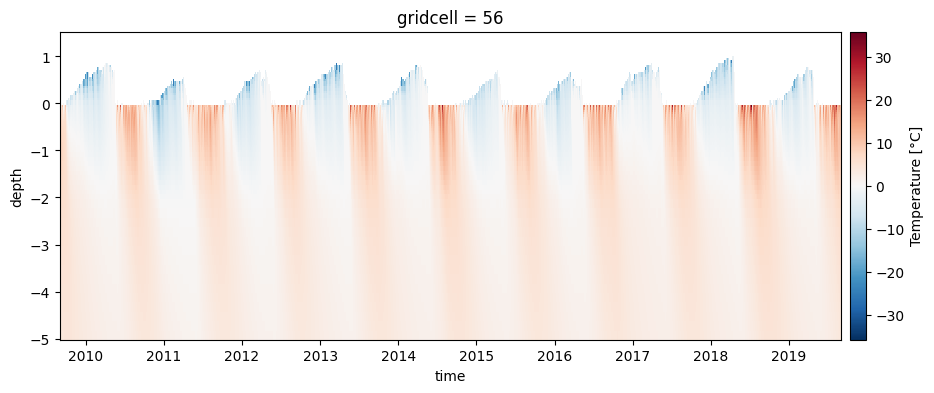

In [16]:
img = out.T[0].plot.imshow(size=4, aspect=3, cbar_kwargs=dict(pad=0.01, label='Temperature [°C]'))

# Reading struct files from MATLAB


Note that `run_info.mat` cannot be read as it contains special classes that are not supported by `scipy.io.loadmat`.  

To save parts of `run_info`, use the following code in MATLAB:


```matlab
run_info_spatial = run_info.SPATIAL.STATVAR
save "run_info_spatial.mat" run_info_spatial
```

In [6]:
fname = '/Users/luke/SDSC/CryoGrid/cryogrid-ITCH-ML/data/spatial_simulations/run_spatial_statvar.mat'
spatial = cgt.read_mat_struct_as_dataset(fname, index=['Y', 'X'])
spatial

<xarray.Dataset> Size: 1MB
Dimensions:         (Y: 178, X: 149)
Coordinates:
  * Y               (Y) int32 712B 6898675 6898700 6898725 ... 6903075 6903100
  * X               (X) int32 596B 274107 274132 274157 ... 277757 277782 277807
Data variables:
    latitude        (Y, X) float64 212kB 62.15 62.15 62.15 ... 62.19 62.19 62.19
    longitude       (Y, X) float64 212kB 10.66 10.66 10.66 ... 10.73 10.73 10.73
    key             (Y, X) uint16 53kB 1 179 357 535 ... 25988 26166 26344 26522
    mask            (Y, X) uint8 27kB 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    altitude        (Y, X) float64 212kB 944.8 952.9 959.9 ... 848.4 843.0 838.0
    slope_angle     (Y, X) float64 212kB 23.31 21.27 17.86 ... 13.59 13.29 12.32
    aspect          (Y, X) float64 212kB 312.4 314.1 317.5 ... 118.9 122.9 122.0
    skyview_factor  (Y, X) float64 212kB 0.9592 0.9659 0.9759 ... 0.9866 0.9885
    horizon_bins    (Y, X) uint8 27kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    horizon_angles  (Y, X) uint8 27kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

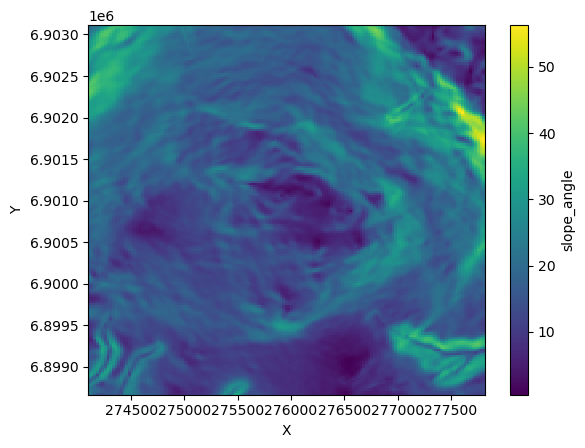

In [5]:
spatial.slope_angle.plot()

# Reading Excel config files

This is experimental. Could be used to run checks on files, and configurations for the model.

In [4]:
fname = '/Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat_debug_v2/strat_debug_v2.xlsx'
config = cgt.CryoGridConfigExcel(fname, check_file_paths=True, check_strat_layers=True)

2025-01-20 15:13:27 | INFO     - Found root path: /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov
2025-01-20 15:13:27 | SUCCESS  - Loaded CryoGrid Excel configuration file: /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat_debug_v2/strat_debug_v2.xlsx
2025-01-20 15:13:27 | INFO     - Checking file locations...
2025-01-20 15:13:27 | SUCCESS  - Located file: /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/forcing/cryogrid-pamir_abramov-era5-1970_2020.mat
2025-01-20 15:13:27 | SUCCESS  - Located file: /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/forcing/cryogrid-pamir_abramov-dem_30m.tif
2025-01-20 15:13:27 | SUCCESS  - Located file: /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/forcing/cryogrid-pamir_abramov-stratigraphy-4types-30m.tif
2025-01-20 15:13:27 | INFO     - Checking stratigraphy layers...
2025-01-20 15:13:27 | SUCCESS  - [STRAT_layers_1]  parameters passed checks
2025-01-20 15:13:27 | SUCCESS  - [STRAT_layers_2]  parameters passed checks
2025-01-20 15:13:27 

I had a quick look and I think the problem is that you have field capacity = porosity, both seem to be 0.2 in the top layer? This is not really intended to work in this code and also doesn't really make much sense, like in this case water would never flow downwards regardless of saturation. What seems to happen is that the uppermost grid cell is completely saturated, but since saturation is only computed from the water in excess of field capacity (which is 0 by definition with your settings), the resulting saturation is 0 and the model thinks that it can add more water and allows for a water flux instead of routing rainwater out. The timestep is then later computed using that water flux, so that the grid cell never overfills, like not more water is added than there is free space. But since there is no space left (0 or very close to 0 due to numerical precision), the timestep becomes 0 or very small. 

 Try reducing the field capacity to 0.1, like porosity/2 or something like that. Not sure that's the full story, but it could be! Let me know if there's still problems pooping up!

# Reading ERA5 forcing data

In [2]:
fname = '../../SDSC/CryoGrid/cryogrid-pamir/abramov/forcing/cryogrid-pamir_abramov-era5-1970_2020.mat'
ds = cgt.forcing.read_mat_ear5(fname)
ds

<xarray.Dataset> Size: 459MB
Dimensions:  (lon: 3, lat: 2, level: 11, time: 149024)
Coordinates:
  * lon      (lon) float32 12B 71.5 71.75 72.0
  * lat      (lat) float32 8B 39.75 39.5
  * level    (level) int64 88B 50000 55000 60000 65000 ... 90000 95000 100000
  * time     (time) float64 1MB 7.195e+05 7.195e+05 ... 7.382e+05 7.382e+05
Data variables: (12/21)
    Zs       (lat, lon) float64 48B 3.656e+03 3.679e+03 ... 3.324e+03 3.203e+03
    u10      (time, lat, lon) float64 7MB -0.3 0.53 -0.07 ... 0.19 0.43 -0.21
    v10      (time, lat, lon) float64 7MB 2.14 2.2 1.71 ... -1.45 -1.01 -0.81
    ps       (time, lat, lon) float64 7MB 6.48e+04 6.46e+04 ... 6.8e+04 6.91e+04
    Td2      (time, lat, lon) float64 7MB -15.72 -16.07 -17.65 ... -33.16 -34.75
    T2       (time, lat, lon) float64 7MB -12.81 -13.12 -13.67 ... -28.04 -26.75
    ...       ...
    wind_sf  float64 8B 0.01
    q_sf     float64 8B 1e-06
    ps_sf    float64 8B 100.0
    rad_sf   float64 8B 0.1
    T_sf     float64 8B 0.01
    P_sf     float64 8B 0.01
Attributes:
    info:     Data read in from CryoGrid ERA5 forcing file. Data has been sca...
    source:   /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/forcing/cryogr...

In [ ]:
fname = '/Users/luke/SDSC/CryoGrid/cryogrid-ITCH-ML/data/Tronfjell_summit.mat'
forcing = cgt.read_mat_struct_as_dataset(fname, index='timeForcing', index_is_datenum=1)
forcing

<xarray.Dataset> Size: 28MB
Dimensions:       (timeForcing: 236688)
Coordinates:
  * timeForcing   (timeForcing) datetime64[ns] 2MB 1940-01-01 ... 2020-12-31T...
Data variables: (12/14)
    Tair          (timeForcing) float64 2MB -16.73 -14.74 ... -10.58 -10.85
    q             (timeForcing) float64 2MB 0.001008 0.001211 ... 0.001741
    wind          (timeForcing) float64 2MB 4.6 5.266 6.221 ... 2.616 1.707
    Sin_dir       (timeForcing) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Sin_dif       (timeForcing) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Sin           (timeForcing) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...            ...
    p             (timeForcing) float64 2MB 8.247e+04 8.256e+04 ... 8.175e+04
    precip        (timeForcing) float64 2MB 0.0 0.0 0.0 ... 2.944 3.937 0.6699
    snowfall      (timeForcing) float64 2MB 0.0 0.0 0.0 ... 8.819 11.79 2.007
    rainfall      (timeForcing) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    azimuth       (timeForcing) float64 2MB 165.6 110.7 70.36 ... 272.7 227.6
    sunElevation  (timeForcing) float64 2MB -50.35 -36.42 ... -24.8 -44.19

# Creating forcing data (optional extra with additional dependencies)

I've built this as an extra module. To install the dependencies, you have to run 
```bash
pip install cryogrid_pytools[data]
```

There are a lot of additional requirements, so not recommended if you don't want to create forcing data. 

In [1]:
from cryogrid_pytools import data

In [2]:
# bbox created with http://bboxfinder.com/
bbox_WSEN = (71.44175183508192, 39.565609290405106, 71.70823768450587, 39.75237924473069)

### Downloading ERA5 data

Note this is simply a wrapper around the `era5_downloader` package that I also wrote. You can install this on its own with `pip install era5_downloader`.

Usage for that would be similar as shown below and there are fewer dependencies. The command to replicate the code below would be:

```python
era5_downloader = era5_downloader.create_cryogrid_forcing_fetcher(
    bbox_WSEN, region_name="abramov", dest_path=...)

In [3]:
era5_downloader = data.make_era5_downloader(
    bbox_WSEN=bbox_WSEN,
    region_name='abramov_glacier',
    dest_path='./data/era5-{region_name}/{time:%Y}/era5-cryogrid_forcing-{region_name}-{time:%Y%m%d}.nc')

fname = era5_downloader.download("2019-01-01")  # downloads data for given date with the default configuration

# to create all data use the following - but note this can take days since you're downloading a lot of data
# flist = [era5_downloader.download(t) for t in pd.date_range('1960-01-01', '2024-10-01')]

2025-01-17 16:00:22.151 | INFO     | era5_downloader.core.__init__:547 | Initialized ERA5Downloader with 
ERA5Downloader(
    bbox = (71.44175183508192, 39.565609290405106, 71.70823768450587, 39.75237924473069), 
    levels = (300, 500, 600, 700, 800, 850, 900, 1000), 
    variables = (
        'geopotential',
        'temperature',
        'specific_humidity',
        'u_component_of_wind',
        'v_component_of_wind',
        '2m_dewpoint_temperature',
        'surface_thermal_radiation_downwards',
        'surface_solar_radiation_downwards',
        'toa_incident_solar_radiation',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        'surface_pressure',
        'total_precipitation',
        '2m_temperature'), 
    cache_path = '/Users/luke/Git/CryoGrid-pyTools/era5_downloader_tmp/20250117160020_k2fsp60f', 
    time_steps = (0, 3, 6, 9, 12, 15, 18, 21), 
    dest_path = './data/era5-abramov_glacier/{YYYY}/era5-cryogrid_forcing-abramov_glacier-{YYYYMMDD}.nc'

### Downloading data for spatial simulations

This includes:

- Copernicus 30 m DEM
- ESA land cover data for creating speculative stratigraphies (if you have no other option)
- Glacier masks from Randolph Glacier Inventory
- Mean snow melt day of year from 2018 to 2024 using Sentinel-2 scene classification data


In [4]:
dem = data.get_dem_copernicus30(bbox_WSEN).load()
land_class = data.get_esa_land_cover(dem)  # can pass bbox or dem 
glaciers = data.get_randolph_glacier_inventory(dem, dest_dir='./data/randolph_glacier_inventory')
snow_melt = data.get_snow_melt_doy(dem)

2025-01-17 16:01:22.812 | INFO     | cryogrid_pytools.data.get_dem_copernicus30:87 | Fetching COP DEM Global 30m data from Planetary Computer
2025-01-17 16:01:24.557 | INFO     | cryogrid_pytools.data.get_esa_land_cover:161 | Fetching ESA World Cover (v2.0) data from Planetary Computer


100%|█████████████████████████████████████| 92.0M/92.0M [00:00<00:00, 95.2GB/s]
SHA256 hash of downloaded file: d21529f1b13b9e206806d30abef3cb31ebdd633f57484670f2a2592bffb9fdd6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
Unzipping contents of '/Users/luke/Git/CryoGrid-pyTools/data/randolph_glacier_inventory/RGI2000-v7.0-G-13_central_asia.zip' to '/Users/luke/Git/CryoGrid-pyTools/data/randolph_glacier_inventory/RGI2000-v7.0-G-13_central_asia.zip.unzip'


2025-01-17 16:02:14.984 | INFO     | cryogrid_pytools.data.get_randolph_glacier_inventory:242 | RGI: Fetching Randolph Glacier Inventory - see https://www.glims.org/rgi_user_guide/welcome.html
2025-01-17 16:02:15.224 | INFO     | cryogrid_pytools.data.get_sentinel2_data:192 | Getting Sentinel-2 SCL granules @30m for 2018 with max cloud cover = 10%
2025-01-17 16:02:16.335 | INFO     | cryogrid_pytools.data.get_sentinel2_data:192 | Getting Sentinel-2 SCL granules @30m for 2019 with max cloud cover = 10%
2025-01-17 16:02:17.313 | INFO     | cryogrid_pytools.data.get_sentinel2_data:192 | Getting Sentinel-2 SCL granules @30m for 2020 with max cloud cover = 10%
2025-01-17 16:02:18.141 | INFO     | cryogrid_pytools.data.get_sentinel2_data:192 | Getting Sentinel-2 SCL granules @30m for 2021 with max cloud cover = 10%
2025-01-17 16:02:18.959 | INFO     | cryogrid_pytools.data.get_sentinel2_data:192 | Getting Sentinel-2 SCL granules @30m for 2022 with max cloud cover = 10%
2025-01-17 16:02:20.75

RuntimeError: Error opening 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/42/T/XK/2018/09/29/S2B_MSIL2A_20180929T060629_N0212_R134_T42TXK_20201009T061658.SAFE/GRANULE/L2A_T42TXK_A008168_20180929T061733/IMG_DATA/R20m/T42TXK_20180929T060629_SCL_20m.tif?st=2025-01-16T15%3A02%3A16Z&se=2025-01-17T15%3A47%3A16Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-01-17T10%3A40%3A51Z&ske=2025-01-24T10%3A40%3A51Z&sks=b&skv=2024-05-04&sig=z7kZV1G2ydA6FjRzscfl8%2BcepisjVQYdISa9cq9Xbiw%3D': RasterioIOError('CURL error: Could not resolve host: sentinel2l2a01.blob.core.windows.net')